In [1]:
import pandas as pd
from statsmodels.stats.proportion import proportion_confint as ci
from natsort import natsorted
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
def get_clean_cape_dataframe(filepath):
    """
    read the cleaned data as dataframe
    Args:
        filepath: str
        the location of the csv file
    Returns:
        dataframe
    """
    df = pd.read_csv(filepath)
    return df

In [3]:
def get_depts_and_courses_dictionary(df):
    """
    get all courses for departments
    Args:
        df: dataframe

    Returns:
        depths_courses: dict

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_depts_and_courses_dictionary(df)
        depths_courses = {'AAS': ['10', '11', '170', '190'], 'ANAR': ['100', '114', '115', '116', '135', '135S', '143']}

    """
    df = (df['Course_ID'].str.split(expand=True)
          .rename(columns={0: 'dept', 1: 'course'})
          .drop_duplicates())

    depts = natsorted(df.dept.unique())
    df = df.set_index(['dept', 'course']).sort_index()

    depts_courses = {dept: natsorted(df.loc[dept].index) for dept in depts}

    return depts_courses

In [4]:
def get_global_avg_time(df):
    """
    return the average time and stand deviation for all courses
    """
    gb = df[['Course_ID', 'time']]
    global_average = float(gb.mean())
    global_sd = float(gb.std())
    
    return global_average, global_sd
    
def get_time_df(df, global_average, global_sd):
    """
    group the dataframe using the Course_ID, the average spending time for a particular course between different terms is calculated
    compare the time with other courses
    Args:
        df
    Returns:
        gb: dataframe

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_time_df(df)
           
        new_df:
            Course_ID  time  depart_avg_time  global_avg_time  depart_time_diff  global_time_diff              
        0       AAS 10  4.07             3.75         5.494174              0.32         -1.424174
        1      AAS 170  3.61             3.75         5.494174             -0.14         -1.884174  
        2      AAS 190  2.93             3.75         5.494174             -0.82         -2.564174  
        3     ANAR 100  3.17             4.10         5.494174             -0.93         -2.324174  
        4     ANAR 116  3.59             4.10         5.494174             -0.51         -1.904174  
    """

    df = df[['Course_ID', 'time']]
    # groupby to get average time for same courses in different quarters
    gb = df[['time', 'Course_ID']].groupby('Course_ID').mean().round(2)
    # print(gb)

    # for departments
    depths_time = {}
    depths_courses = get_depts_and_courses_dictionary(df)
    for dept, courses in depths_courses.items():
        times = []
        for course in courses:
            mask = df['Course_ID'].str.startswith(dept + ' ' + course)
            if mask.any():
                times.extend(df.loc[mask, 'time'])

        if times:
            average_time = np.mean(times)
            std_deviation = np.std(times)
            depths_time[dept] = (average_time, std_deviation)

    # for all courses
#     global_average = float(gb.mean())
#     global_sd = float(gb.std())

    df['department'] = df['Course_ID'].str.split().str[0]
    df['depart_avg_time'] = df['department'].map(lambda x: depths_time[x][0] if x in depths_time else None)

    gb = df.groupby('Course_ID').mean().round(2).reset_index()
    gb['global_avg_time'] = global_average
    gb['depart_time_diff'] = gb['time'] - gb['depart_avg_time']
    gb['global_time_diff'] = gb['time'] - global_average

    return gb

In [5]:
def get_grade_dev_df(df):
    """
    group the dataframe using the Course_ID, the average expected and actual gpa for a particular course between different terms is calculated
    compare the expected gpa and actual gpa
    Args:
        df
    Returns:
        gb: dataframe

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_grade_dev_df(df)

        new_df:
                Course_ID  expected_gpa  actual_gpa   dev
            0       AAS 10          3.79        3.56 -0.23
            1      AAS 170          3.89        3.68 -0.21
            2      AAS 190          3.86        4.00  0.14
            3     ANAR 100          3.33        3.30 -0.03
            4     ANAR 116          3.70        3.35 -0.35
            ...        ...           ...         ...   ...
            1205   VIS 70N          3.78        3.60 -0.18
            1206    VIS 80          3.84        3.82 -0.02
            1207  WCWP 100          3.54        3.49 -0.05
            1208  WCWP 10A          3.73        3.65 -0.08
            1209  WCWP 10B          3.55        3.50 -0.05
                            
    """
    df = df[['Course_ID', 'expected_gpa', 'actual_gpa']]

    # groupby to get the mean grade and round to 2 decimal places
    gb = df.groupby('Course_ID').mean().round(2).reset_index()
    gb['dev'] = gb['actual_gpa'] - gb['expected_gpa']

    return gb


In [6]:
def get_class_rmd_df(df):
    """
    group the dataframe using the Course_ID, the average class recommendation ratio for a particular course between different terms is calculated
    Args:
        df
    Returns:
        gb: dataframe

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_class_rmd_df(df)

        new_df:
             Course_ID  rmd_class
        0       AAS 10      85.68
        1       AAS 11      93.50
        2      AAS 170      94.45
        3      AAS 190     100.00
        4     ANAR 100     100.00
        ...        ...        ...
        2447    VIS 84      80.55
        2448     VIS 9      80.60
        2449  WCWP 100      92.66
        2450  WCWP 10A      91.66
        2451  WCWP 10B      90.33
    """
    df = df[['Course_ID', 'rmd_class']]
    # groupby to get the mean course recommendation ratio and round to 2 decimal places
    gb = df.groupby(['Course_ID']).mean().round(2).reset_index()
    
    return gb

In [7]:
def get_instr_rmd_df(df):
    """
    group the dataframe using the Course_ID, the average instructor recommendation ratio for a particular course between different terms is calculated
    Args:
        df
    Returns:
        gb: dataframe

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_instr_rmd_df(df):

        new_df:
                Course_ID                        instr  rmd_instr
        0       AAS 10    Butler, Elizabeth Annette      88.63
        1      AAS 170    Butler, Elizabeth Annette      88.90
        2      AAS 190  Puritty, Chandler Elizabeth     100.00
        3     ANAR 100                Fortier, Jana     100.00
        4     ANAR 116            Shtienberg, Gilad     100.00
        ...        ...                          ...        ...
        2256  WCWP 10A              Savage, Sarah S     100.00
        2257  WCWP 10A                Susi, Natalie      97.10
        2258  WCWP 10B            Gagnon, Jeffrey C      95.80
        2259  WCWP 10B           Tocki, Jasmine Rae     100.00
        2260  WCWP 10B         Welji, Haleema Nazir      93.30
    """
    df = df[['Course_ID', 'instr', 'rmd_instr']]

    # groupby to get the mean grade and round to 2 decimal places
    gb = df.groupby(['Course_ID','instr']).mean().round(2).reset_index()
    
    return gb

In [8]:
df = get_clean_cape_dataframe('data_clean.csv')

In [9]:
df

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa
0,"Butler, Elizabeth Annette",SP23,66,48,93.5,100.0,2.80,AAS 10,Intro/African-American Studies (A),A-,3.84,B+,3.67
1,"Butler, Elizabeth Annette",SP23,20,7,100.0,100.0,2.50,AAS 170,Legacies of Research (A),A-,3.86,A-,3.92
2,"Shtienberg, Gilad",SP23,26,6,100.0,83.3,3.83,ANAR 115,Coastal Geomorphology/Environ (A),B+,3.50,B,3.07
3,"Braswell, Geoffrey E.",SP23,22,9,100.0,100.0,5.17,ANAR 155,Stdy Abrd: Ancient Mesoamerica (A),A,4.00,A,4.00
4,"Hrvoj Mihic, Branka",SP23,22,4,100.0,100.0,2.50,ANBI 111,Human Evolution (A),A,4.00,B-,2.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15400,"Blomstedt, Elizabeth Ann",SP19,20,6,100.0,100.0,4.50,WCWP 100,Academic Writing (B),B+,3.60,B+,3.42
15401,"McCleary, Keith Long",SP19,20,19,84.2,94.4,8.39,WCWP 100,Academic Writing (C),B-,2.95,B,3.17
15402,"Young, Mark T",SP19,20,8,75.0,87.5,8.00,WCWP 100,Academic Writing (F),B,3.13,B+,3.34
15403,"Gagnon, Jeffrey C",SP19,150,126,76.9,91.5,5.21,WCWP 10A,The Writing Course A (0),B,3.11,B,3.21


## Input the weights

Please provide your preferences for each category on a scale of 1 to 10, separated by spaces

(GPA, Time Spent, Exp vs True GPA, % Rec Course, % Rec Prof):

For example, enter: 10 10 5 5 5

In [10]:
user_input = input("Enter ratings separated by spaces: ")
ratings = list(map(int, user_input.split()))

def weights(ratings):
    '''
    Calculate weights based on rankings
    
    Args:
        ratings: input ratings
    
    Return:
        list: ration of ratings to sum of all ratings
    
    '''
    weights = []
    for i in ratings:
        weights.append(i/sum(ratings))
    return weights
        

Enter ratings separated by spaces: 10 10 10 5 5


In [11]:
weights = weights(ratings)
print(weights)

[0.25, 0.25, 0.25, 0.125, 0.125]


## Input the desired quarters

Please input a space seperated list of desired quarters using the corresponding numbers:

1. Fall
2. Winter
3. Spring
4. Summer Session 1
5. Summer Session 2

For example, entering `1 2 3` will select Fall, Winter, and Spring.

In [12]:
quarters = list(map(int, input("Enter quarter numbers separated by spaces: ").split(' ')))
quarters

Enter quarter numbers separated by spaces: 1 2


[1, 2]

## Input the desired depeartments

Please input a space seperated list of desired quarters 
Ex: ECE CSE

In [13]:
user_input = input("Enter department names separated by spaces: ")

depts = user_input.split()

depts

Enter department names separated by spaces: ECE CSE


['ECE', 'CSE']

In [14]:
maps = {1: 'FA', 2:'WI', 3:'SP', 4: 'S1', 5:'S2'}

# maps quarters to string name and slices df based on quarters
quarter_str = '|'.join([maps[q] for q in quarters])
df2 = df[df['term'].str.contains(quarter_str)].reset_index(drop=True)
df2

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa
0,"Butler, Elizabeth Annette",WI23,65,46,93.5,93.3,4.15,AAS 11,Intro Black Diasporic Studies (A),A-,3.84,A-,3.71
1,"Shtienberg, Gilad",WI23,27,9,100.0,100.0,3.61,ANAR 116,Sea Level ChangeIsrael (A),A,4.00,B+,3.62
2,"Braswell, Geoffrey E.",WI23,24,15,100.0,92.9,3.42,ANAR 135,Ancient Mediterranean Civ (A),A,4.00,A-,3.99
3,"Rodriguez, Eric Andrew",WI23,41,23,100.0,100.0,4.07,ANAR 164,Underwater Archaeology (A),A-,3.80,B+,3.63
4,"Non, Amy L",WI23,71,45,84.4,81.8,4.28,ANBI 130,Biology of Inequality (A),B+,3.42,B+,3.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8435,"Cho, Erica",FA19,127,78,81.6,70.7,6.47,VIS 70N,Introduction to Media (A),B+,3.64,B+,3.59
8436,"Tonies, Joshua Vanjaymes",FA19,115,96,97.9,98.9,9.43,VIS 80,Introduction to Studio Major (A),B+,3.67,B+,3.65
8437,"McCleary, Keith Long",FA19,20,20,95.0,100.0,8.70,WCWP 100,Academic Writing (B),B,3.00,B,3.28
8438,"Gagnon, Jeffrey C",FA19,697,398,74.3,86.9,4.77,WCWP 10A,The Writing Course A (0),B+,3.39,B,3.28


In [15]:
df_quarter = df2[df2['Course_ID'].str.contains('|'.join(depts))].reset_index(drop=True)
df_quarter

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa
0,"Moshiri, Alexander Niema",WI23,188,133,97.0,98.5,7.82,CSE 100,Advanced Data Structures (A),B+,3.60,B+,3.36
1,"Moshiri, Alexander Niema",WI23,315,250,98.8,98.4,7.87,CSE 100R,Advanced Data Structures (A),B+,3.68,B+,3.47
2,"Kane, Daniel Mertz",WI23,425,169,86.7,88.3,12.24,CSE 101,Design & Analysis of Algorithm (A),B,3.10,B,3.08
3,"Jones, Miles E",WI23,340,142,84.2,94.9,8.51,CSE 105,Theory of Computation (A),B+,3.49,B,3.25
4,"Bellare, Mihir",WI23,56,11,90.9,90.9,6.14,CSE 107,Intro to Modern Cryptography (A),A-,3.70,B-,2.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,"Eldon, John",FA19,163,81,97.1,96.9,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58
575,"Gilja, Vikash",FA19,163,81,97.1,100.0,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58
576,"Hall, Drew A.",FA19,163,81,97.1,98.4,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58
577,"Nguyen, Truong Quang",FA19,163,81,97.1,100.0,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58


In [18]:
# Convert rows to numeric
df_quarter['actual_gpa'] = pd.to_numeric(df_quarter['actual_gpa'], errors='coerce')
df_quarter['rmd_class'] = pd.to_numeric(df_quarter['rmd_class'], errors='coerce')
df_quarter['rmd_instr'] = pd.to_numeric(df_quarter['rmd_instr'], errors='coerce')
df_quarter['time'] = pd.to_numeric(df_quarter['time'], errors='coerce')
df_quarter['gpa_diff'] = pd.to_numeric(df_quarter['actual_gpa'], errors='coerce') - pd.to_numeric(df_quarter['expected_gpa'], errors='coerce')

# Calculates the percentile of each entry based on other entries in filtered dataframe
df_quarter['actual_gpa_percentile'] = df_quarter['actual_gpa'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['actual_gpa'], x))
df_quarter['rmd_class_percentile'] = df_quarter['rmd_class'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['rmd_class'], x))
df_quarter['rmd_instr_percentile'] = df_quarter['rmd_instr'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['rmd_instr'], x))
df_quarter['time_percentile'] = df_quarter['time'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['time'], x))
df_quarter['gpa_diff_percentile'] = df_quarter['gpa_diff'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['gpa_diff'], x))


df_quarter

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa,gpa_diff,actual_gpa_percentile,rmd_class_percentile,rmd_instr_percentile,time_percentile,gpa_diff_percentile
0,"Moshiri, Alexander Niema",WI23,188,133,97.0,98.5,7.82,CSE 100,Advanced Data Structures (A),B+,3.60,B+,3.36,-0.24,59.067358,83.419689,83.160622,34.369603,34.024180
1,"Moshiri, Alexander Niema",WI23,315,250,98.8,98.4,7.87,CSE 100R,Advanced Data Structures (A),B+,3.68,B+,3.47,-0.21,67.616580,91.537133,82.469775,34.887737,39.723661
2,"Kane, Daniel Mertz",WI23,425,169,86.7,88.3,12.24,CSE 101,Design & Analysis of Algorithm (A),B,3.10,B,3.08,-0.02,27.288428,39.205527,37.737478,90.328152,70.034542
3,"Jones, Miles E",WI23,340,142,84.2,94.9,8.51,CSE 105,Theory of Computation (A),B+,3.49,B,3.25,-0.24,46.632124,32.124352,63.212435,48.618307,34.024180
4,"Bellare, Mihir",WI23,56,11,90.9,90.9,6.14,CSE 107,Intro to Modern Cryptography (A),A-,3.70,B-,2.76,-0.94,9.930915,54.490501,44.300518,10.535406,0.172712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,"Eldon, John",FA19,163,81,97.1,96.9,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58,-0.14,80.051813,84.283247,74.179620,16.925734,49.136442
575,"Gilja, Vikash",FA19,163,81,97.1,100.0,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58,-0.14,80.051813,84.283247,93.436960,16.925734,49.136442
576,"Hall, Drew A.",FA19,163,81,97.1,98.4,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58,-0.14,80.051813,84.283247,82.469775,16.925734,49.136442
577,"Nguyen, Truong Quang",FA19,163,81,97.1,100.0,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58,-0.14,80.051813,84.283247,93.436960,16.925734,49.136442


In [19]:
# (GPA, Time Spent, Exp vs True GPA, % Rec Course, % Rec Prof):

df_quarter['rec_score'] = weights[0] * df_quarter['actual_gpa_percentile'] + \
                    weights[1] * df_quarter['time_percentile'] + \
                    weights[2] * df_quarter['gpa_diff_percentile'] + \
                    weights[3] * df_quarter['rmd_class_percentile'] + \
                    weights[4] * df_quarter['rmd_instr_percentile']
df_quarter

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa,gpa_diff,actual_gpa_percentile,rmd_class_percentile,rmd_instr_percentile,time_percentile,gpa_diff_percentile,rec_score
0,"Moshiri, Alexander Niema",WI23,188,133,97.0,98.5,7.82,CSE 100,Advanced Data Structures (A),B+,3.60,B+,3.36,-0.24,59.067358,83.419689,83.160622,34.369603,34.024180,52.687824
1,"Moshiri, Alexander Niema",WI23,315,250,98.8,98.4,7.87,CSE 100R,Advanced Data Structures (A),B+,3.68,B+,3.47,-0.21,67.616580,91.537133,82.469775,34.887737,39.723661,57.307858
2,"Kane, Daniel Mertz",WI23,425,169,86.7,88.3,12.24,CSE 101,Design & Analysis of Algorithm (A),B,3.10,B,3.08,-0.02,27.288428,39.205527,37.737478,90.328152,70.034542,56.530656
3,"Jones, Miles E",WI23,340,142,84.2,94.9,8.51,CSE 105,Theory of Computation (A),B+,3.49,B,3.25,-0.24,46.632124,32.124352,63.212435,48.618307,34.024180,44.235751
4,"Bellare, Mihir",WI23,56,11,90.9,90.9,6.14,CSE 107,Intro to Modern Cryptography (A),A-,3.70,B-,2.76,-0.94,9.930915,54.490501,44.300518,10.535406,0.172712,17.508636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,"Eldon, John",FA19,163,81,97.1,96.9,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58,-0.14,80.051813,84.283247,74.179620,16.925734,49.136442,56.336356
575,"Gilja, Vikash",FA19,163,81,97.1,100.0,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58,-0.14,80.051813,84.283247,93.436960,16.925734,49.136442,58.743523
576,"Hall, Drew A.",FA19,163,81,97.1,98.4,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58,-0.14,80.051813,84.283247,82.469775,16.925734,49.136442,57.372625
577,"Nguyen, Truong Quang",FA19,163,81,97.1,100.0,6.76,ECE 5,Intro to ECE (A),A-,3.72,B+,3.58,-0.14,80.051813,84.283247,93.436960,16.925734,49.136442,58.743523


In [20]:
# Trunkates the course name to combine sessions of the same class
df_quarter['Course_Name'] = df_quarter['Course_Name'].str[:-3]

In [21]:
# Groups the classes the course_id and sorts based on the calculated recommendation score
df_group = df_quarter.groupby(['Course_ID','Course_Name']).mean().round(2).reset_index()
df_group = df_group.sort_values(by = 'rec_score', ascending = False).reset_index()
df_group

,index,Course_ID,Course_Name,enroll,evals,rmd_class,rmd_instr,time,expected_gpa,actual_gpa,gpa_diff,actual_gpa_percentile,rmd_class_percentile,rmd_instr_percentile,time_percentile,gpa_diff_percentile,rec_score
0,39,CSE 165,3D User Interaction,41.00,18.00,100.00,100.00,9.28,3.76,3.91,0.15,98.53,96.20,93.44,65.80,90.76,87.48
1,81,ECE 157A,Communications Systems Lab I,22.00,10.00,88.90,100.00,9.17,3.50,3.68,0.18,86.61,46.72,93.44,63.56,92.31,78.14
2,77,ECE 144,LabVIEW Programming,29.60,23.60,95.24,95.96,10.45,3.47,3.60,0.12,80.83,74.68,70.81,69.07,85.41,77.01
3,45,CSE 181,Molecular Sequence Analysis,20.00,15.00,93.30,93.30,14.77,3.67,3.62,-0.05,82.99,65.98,54.84,98.27,65.11,76.69
4,16,CSE 131,Compiler Construction,88.00,63.00,93.50,93.50,11.82,3.55,3.55,0.00,77.12,67.27,56.13,88.95,73.23,75.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,98,ECE 30,Intro to Computer Engineering,94.20,47.00,65.28,75.68,9.23,2.93,2.72,-0.22,12.21,5.68,17.06,59.03,43.11,31.43
99,6,CSE 107,Intro to Modern Cryptography,74.60,21.80,90.46,94.16,7.19,3.46,2.99,-0.47,24.20,53.78,60.79,24.84,17.31,30.91
100,17,CSE 132A,Database System Principles,172.75,56.25,85.48,85.14,6.38,3.43,3.16,-0.27,38.47,37.92,33.43,13.75,33.78,30.42
101,46,CSE 190,Top/Computer Sci & Engineering,28.00,12.00,91.70,100.00,6.68,3.36,2.78,-0.58,10.62,58.20,93.44,15.72,3.63,26.45


In [22]:
# Presents data to user
result = df_group[['Course_ID', 'Course_Name']][0:5]

print('Based on your preferences, these are the top 5 classes we recommend for you: \n')
print(result)

Based on your preferences, these are the top 5 classes we recommend for you: 

  Course_ID                    Course_Name
0   CSE 165           3D User Interaction 
1  ECE 157A  Communications Systems Lab I 
2   ECE 144           LabVIEW Programming 
3   CSE 181   Molecular Sequence Analysis 
4   CSE 131         Compiler Construction 


In [23]:
# factor 1: Time spent
global_average, global_std = get_global_avg_time(df2)
time_factor = get_time_df(df_quarter, global_average, global_std)
time_factor_depart = time_factor[time_factor['Course_ID'].str.contains('|'.join(depts))].copy().reset_index(drop=True)
print(time_factor_depart)

   Course_ID   time  depart_avg_time  global_avg_time  depart_time_diff  \
0    CSE 100  11.01             9.06         5.800227              1.95   
1   CSE 100R   8.17             9.06         5.800227             -0.89   
2    CSE 101  10.06             9.06         5.800227              1.00   
3    CSE 103   6.81             9.06         5.800227             -2.25   
4    CSE 105   8.66             9.06         5.800227             -0.40   
..       ...    ...              ...              ...               ...   
92    ECE 30   9.23             8.67         5.800227              0.56   
93    ECE 35   9.95             8.67         5.800227              1.28   
94    ECE 45   8.07             8.67         5.800227             -0.60   
95     ECE 5   6.45             8.67         5.800227             -2.22   
96    ECE 65   8.24             8.67         5.800227             -0.43   

    global_time_diff  
0           5.209773  
1           2.369773  
2           4.259773  
3      

/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_51447/3903882608.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  global_average = float(gb.mean())
/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_51447/3903882608.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  global_sd = float(gb.std())
/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_51447/3903882608.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

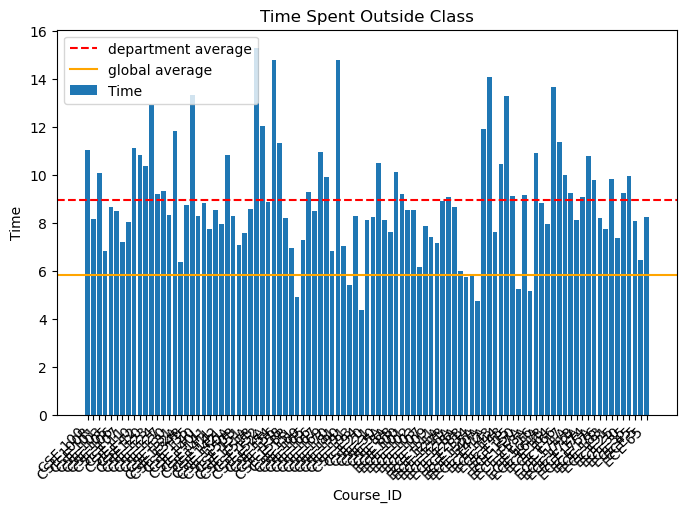

In [24]:
time_draw = time_factor_depart 

plt.figure(figsize=(8, 5))
plt.bar(time_draw['Course_ID'], time_draw['time'], label='Time')

depart_average_time = time_draw['time'].mean()
plt.axhline(y=depart_average_time, color='red', linestyle='--', label='department average')

global_average_time = time_draw['global_avg_time'].mean()
plt.axhline(y=global_average_time, color='orange', linestyle='-', label='global average')

plt.title('Time Spent Outside Class')
plt.xlabel('Course_ID')
plt.ylabel('Time')

plt.xticks(rotation=45, ha='right')

plt.legend()
plt.show()

In [25]:
# factor 2: difference between actual gpa and expected gpa
grade_dev_factor = get_grade_dev_df(df_quarter)
grade_dev_factor_depart = grade_dev_factor[grade_dev_factor['Course_ID'].str.contains('|'.join(depts))].copy().reset_index(drop=True) # should be changed later for different inputs
# grade_dev_factor_depart = grade_dev_factor.loc[time_factor.index.str.startswith('ECE')].copy()  
print(grade_dev_factor_depart)

   Course_ID  expected_gpa  actual_gpa   dev
0    CSE 100          3.50        3.21 -0.29
1   CSE 100R          3.66        3.50 -0.16
2    CSE 101          3.22        3.20 -0.02
3    CSE 103          3.44        3.22 -0.22
4    CSE 105          3.37        3.25 -0.12
..       ...           ...         ...   ...
92    ECE 30          2.93        2.72 -0.21
93    ECE 35          3.00        2.55 -0.45
94    ECE 45          3.01        2.96 -0.05
95     ECE 5          3.75        3.54 -0.21
96    ECE 65          3.43        3.05 -0.38

[97 rows x 4 columns]


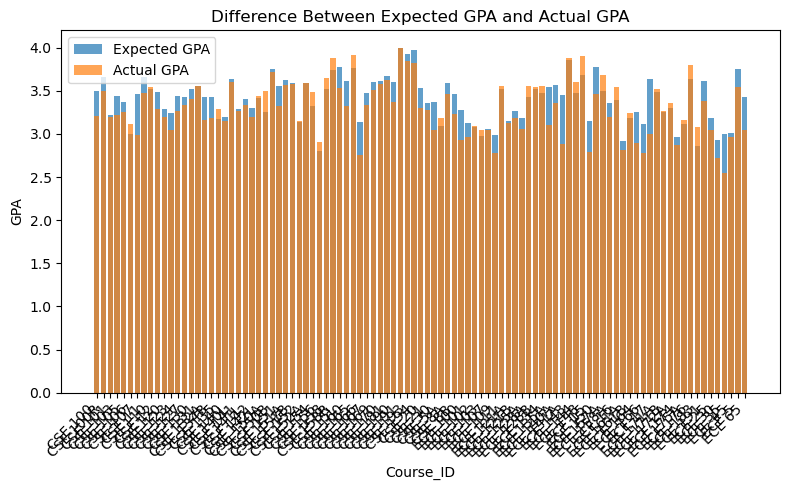

In [26]:
grade_dev_draw = grade_dev_factor_depart  

plt.figure(figsize=(8, 5))

plt.bar(grade_dev_draw['Course_ID'], grade_dev_draw['expected_gpa'], label='Expected GPA', alpha=0.7)
plt.bar(grade_dev_draw['Course_ID'], grade_dev_draw['actual_gpa'], label='Actual GPA', alpha=0.7)


plt.title('Difference Between Expected GPA and Actual GPA')
plt.xlabel('Course_ID')
plt.ylabel('GPA')


plt.xticks(rotation=45, ha='right')

plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# factor 3: gpa got
grade_factor_depart = grade_dev_factor_depart[['actual_gpa']].copy()
print(grade_factor_depart)

    actual_gpa
0         3.21
1         3.50
2         3.20
3         3.22
4         3.25
..         ...
92        2.72
93        2.55
94        2.96
95        3.54
96        3.05

[97 rows x 1 columns]


In [28]:
# gpa plot will not be plotted since it is included in the gpa difference figure. We simply add it as a weight for our recommendation system

In [29]:
# factor 4: % recommend the class
class_factor = get_class_rmd_df(df_quarter)
class_factor_depart = class_factor[class_factor['Course_ID'].str.contains('|'.join(depts))].copy().reset_index(drop=True)
print(class_factor_depart)

   Course_ID  rmd_class
0    CSE 100      96.67
1   CSE 100R      99.15
2    CSE 101      87.12
3    CSE 103      76.72
4    CSE 105      79.81
..       ...        ...
92    ECE 30      65.28
93    ECE 35      86.11
94    ECE 45      70.59
95     ECE 5      97.92
96    ECE 65      94.98

[97 rows x 2 columns]


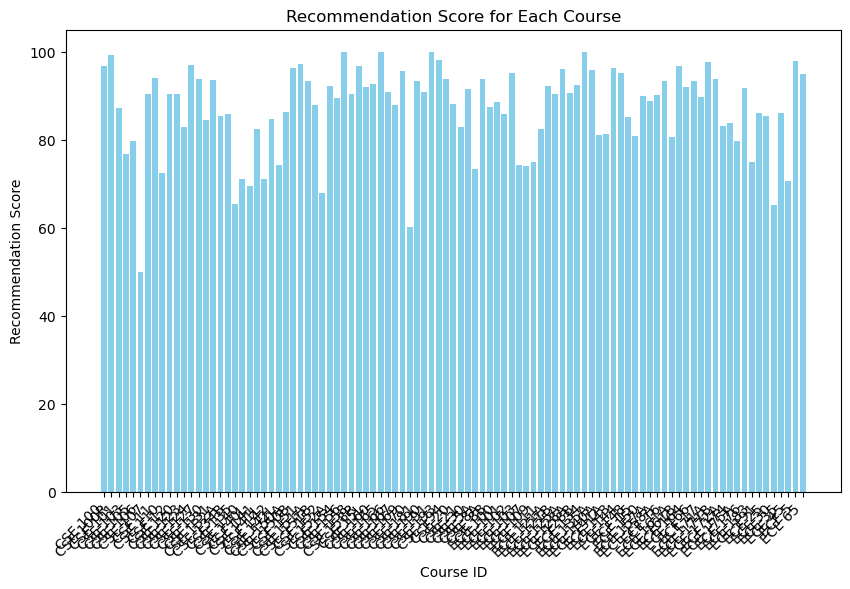

In [30]:
plt.figure(figsize=(10, 6))

plt.bar(class_factor_depart['Course_ID'], class_factor_depart['rmd_class'], color='skyblue')

plt.xlabel('Course ID')
plt.ylabel('Recommendation Score')
plt.title('Recommendation Score for Each Course')

plt.xticks(rotation=45, ha='right')

plt.show()

In [31]:
# factor 5: % recommend the instructor
instr_factor = get_instr_rmd_df(df_quarter)
instr_factor_depart = instr_factor[instr_factor['Course_ID'].str.contains('|'.join(depts))].copy().reset_index(drop=True)
print(instr_factor_depart)

    Course_ID                     instr  rmd_instr
0     CSE 100              Cao, Yingjun      95.08
1     CSE 100  Moshiri, Alexander Niema      98.50
2     CSE 100           Sahoo, Debashis      64.35
3    CSE 100R  Moshiri, Alexander Niema      98.65
4     CSE 101           Jaiswal, Ragesh      32.40
..        ...                       ...        ...
215     ECE 5             Gilja, Vikash      99.67
216     ECE 5             Hall, Drew A.      99.20
217     ECE 5   Morris, Karcher William      97.74
218     ECE 5      Nguyen, Truong Quang     100.00
219    ECE 65      Baghdadchi, Saharnaz      97.85

[220 rows x 3 columns]


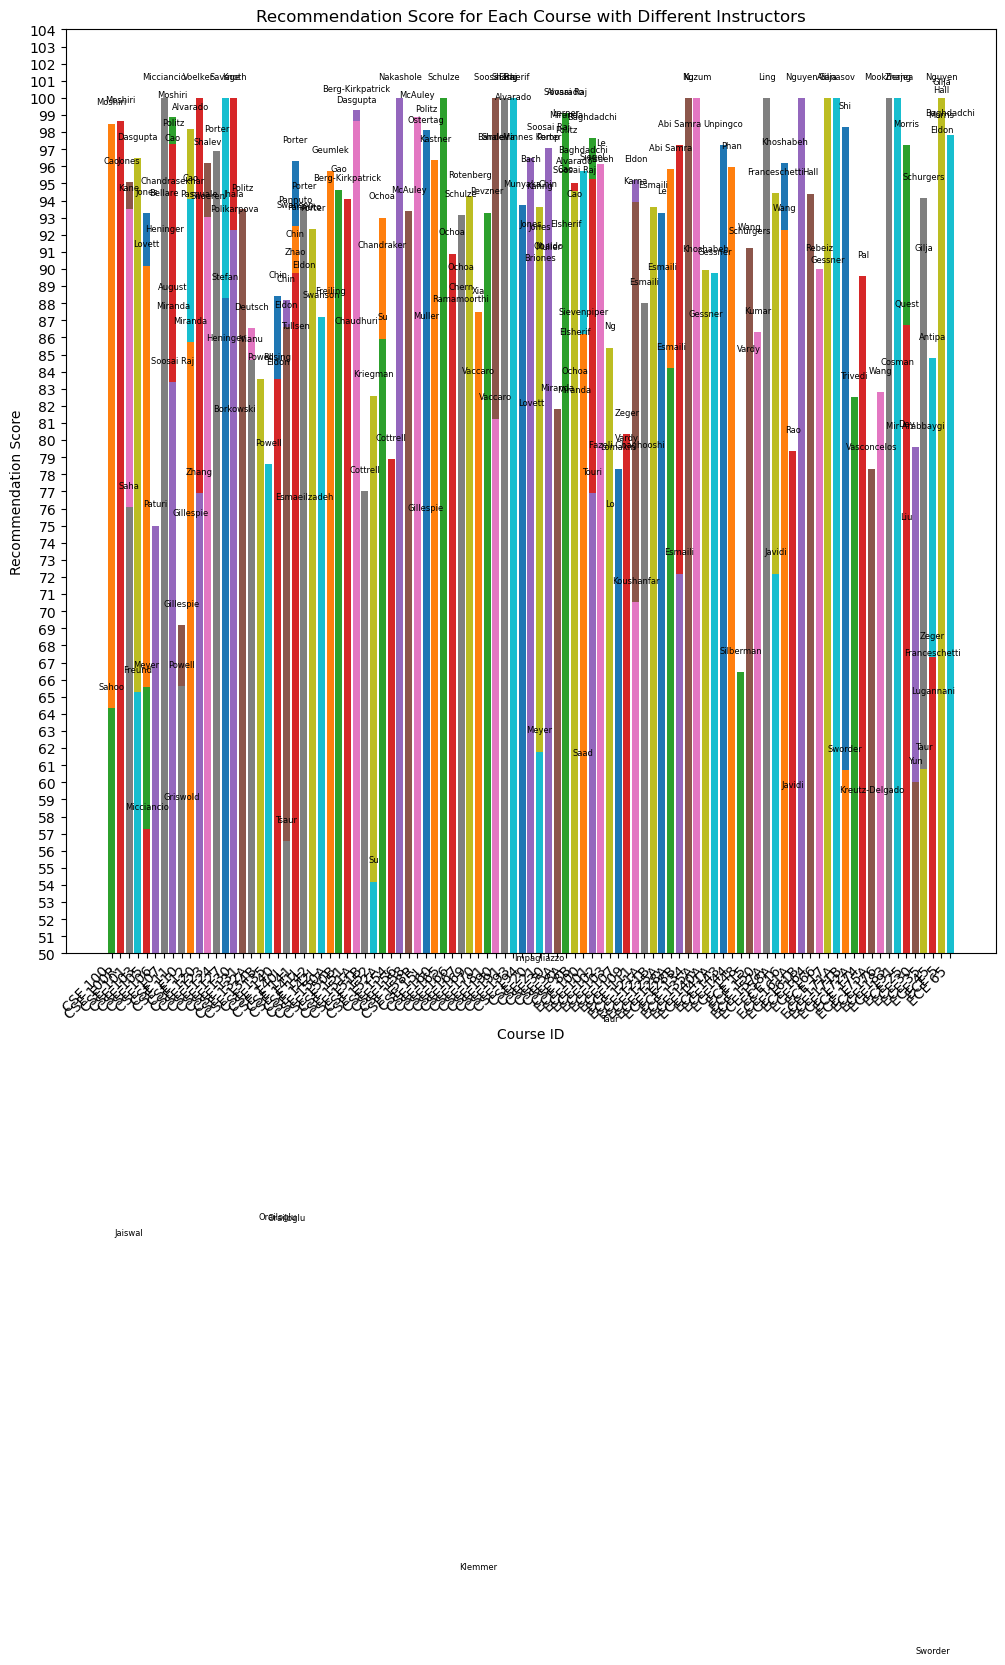

In [32]:
plt.figure(figsize=(12, 12))
for i, course_id in enumerate(instr_factor_depart['Course_ID']):
    plt.bar(course_id, instr_factor_depart['rmd_instr'].iloc[i], label=instr_factor_depart['instr'].iloc[i].split(',')[0])
    plt.text(course_id, instr_factor_depart['rmd_instr'].iloc[i] + 1, instr_factor_depart['instr'].iloc[i].split(',')[0], ha='center', va='bottom', fontsize=6)

plt.xlabel('Course ID')
plt.ylabel('Recommendation Score')
plt.title('Recommendation Score for Each Course with Different Instructors')
plt.xticks(rotation=45, ha='right')
plt.ylim(50, 100)
plt.yticks(range(50, 105))

plt.show()

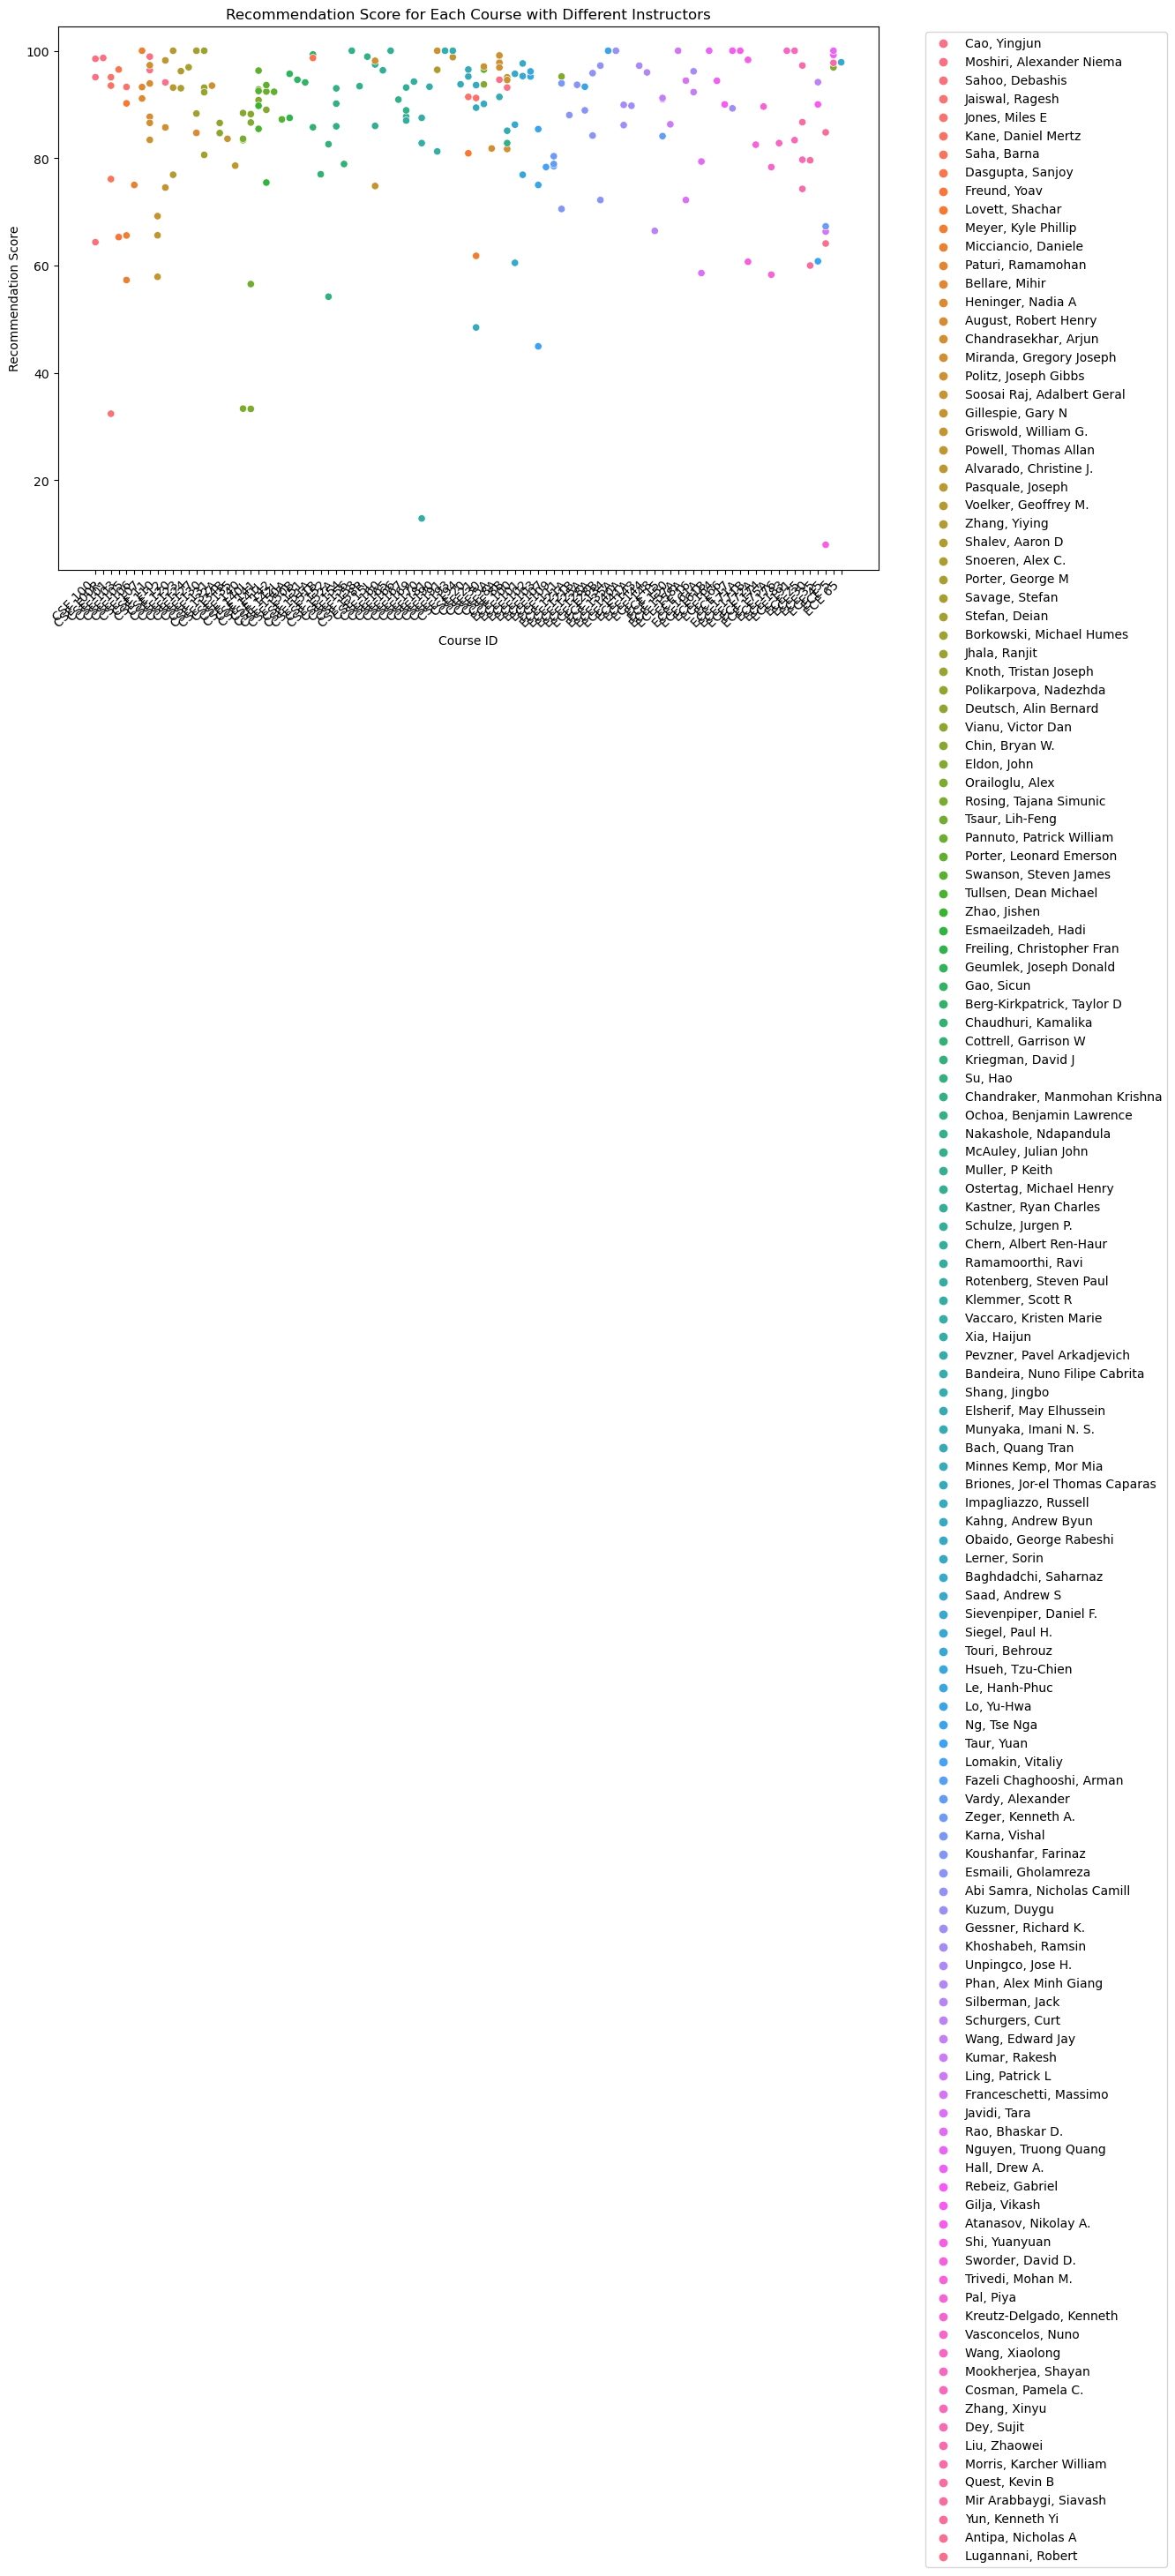

In [33]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Course_ID', y='rmd_instr', hue='instr', data=instr_factor_depart)
plt.xlabel('Course ID')
plt.ylabel('Recommendation Score')
plt.title('Recommendation Score for Each Course with Different Instructors')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.show()

## Check if a specific class is recommended or not

Type the class you are interested in and we will let you know the best professors and if we recommend it or not

Ex. ECE 5


In [34]:
class_in = input("Type you desired class:")
class_in

Type you desired class:CSE 120


'CSE 120'

In [37]:
# Creates dataframe of entries for input class id and sorts by rec_score

df_class = df_quarter[df_quarter['Course_ID'].str.contains(class_in)]
df_class_grouped = df_class.groupby('instr').mean().round(2).reset_index()
df_class_grouped = df_class_grouped.sort_values(by = 'rec_score', ascending = False).reset_index()
df_class_grouped

,index,instr,enroll,evals,rmd_class,rmd_instr,time,expected_gpa,actual_gpa,gpa_diff,actual_gpa_percentile,rmd_class_percentile,rmd_instr_percentile,time_percentile,gpa_diff_percentile,rec_score
0,2,"Zhang, Yiying",286.0,240.00,83.70,76.90,10.42,3.27,3.63,0.36,83.59,30.74,15.80,82.73,97.67,71.82
1,0,"Pasquale, Joseph",193.5,67.25,89.68,93.14,10.09,3.26,3.19,-0.07,40.33,52.71,56.57,74.19,60.59,57.44
2,1,"Voelker, Geoffrey M.",235.0,74.67,94.33,100.00,11.08,3.39,3.06,-0.33,28.76,70.55,93.44,86.18,22.05,54.75


In [38]:
# Presents data to user
result_2 = df_class_grouped[['instr']]

print('Based on your preferences, these are the professors ranked for ' + str(class_in)+ ': \n')
print(result_2)

Based on your preferences, these are the professors ranked for CSE 120: 

                  instr
0         Zhang, Yiying
1      Pasquale, Joseph
2  Voelker, Geoffrey M.
